## Exploring hierarchical clustering of REMAGUS02 cohort

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd

### Loading data sent by Sylvie

In [4]:
df = pd.read_csv("r02_clustering_sylvie.csv", index_col=0, sep='\t')

In [5]:
df.head()

,GROUPE,212093_s_at,212095_s_at,212096_s_at,239576_at,ATIP 3classes : high(3) med(2) low(1)
CLETRI,,,,,,
11001,1,2.293067,4.207343,8.602657,7.333527,1
11002,1,6.083570,6.462007,10.831717,9.031872,3
11008,1,5.316822,5.586858,9.879765,7.684949,2
11009,1,3.247557,3.305827,8.758160,6.189891,1
11013,1,3.775241,4.165393,8.714390,6.259938,1


In [6]:
len(df)

115

In [7]:
# Rename last column with a more manageable name
df.rename(columns={df.columns[-1]:'ATIP3_classes'}, inplace=True)

In [8]:
#clusters_sylvie = np.array(df[df.columns[-1]])

In [9]:
# Names of the ATIP3 low samples
sylvie_atip3_low_names = df[df.ATIP3_classes==1].index

In [10]:
# Number of ATIP3 low samples
len(sylvie_atip3_low_names)

25

In [12]:
# Extract data matrix
X = np.array(df.drop(columns=['ATIP3_classes', 'GROUPE']))
X.shape

(115, 4)

## Data exploration

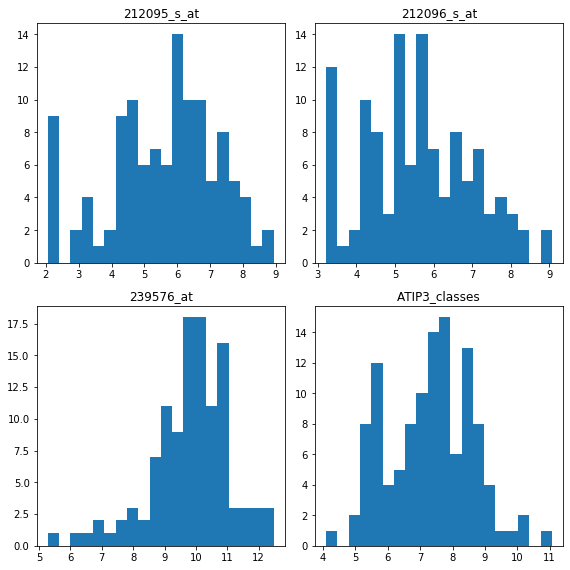

In [13]:
fig = plt.figure(figsize=(8, 8))

# Histograms for continuous features
for idx in range(X.shape[1]):
    # create a subplot in the (idx+1) position of a 2x2 grid
    ax = fig.add_subplot(2, 2, (idx+1))
    # plot the histogram of idx
    h = ax.hist(X[:, idx], bins=20, edgecolor='none')
    # use the name of the feature as a title for each histogram
    ax.set_title(df.columns[idx+2])
# espacement entre les subplots
fig.tight_layout(pad=1.0)

### Scale features 

In [14]:
from sklearn import preprocessing

In [15]:
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.PowerTransformer(method='yeo-johnson')
scaler.fit(X)
X_scaled = scaler.transform(X)

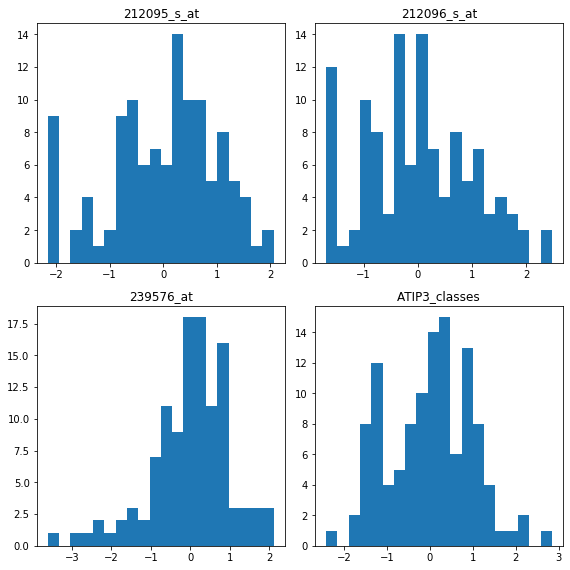

In [16]:
fig = plt.figure(figsize=(8, 8))

# Histograms for continuous features
for idx in range(X_scaled.shape[1]):
    # create a subplot in the (idx+1) position of a 2x2 grid
    ax = fig.add_subplot(2, 2, (idx+1))
    # plot the histogram of idx
    h = ax.hist(X_scaled[:, idx], bins=20, edgecolor='none')
    # use the name of the feature as a title for each histogram
    ax.set_title(df.columns[idx+2])
# espacement entre les subplots
fig.tight_layout(pad=1.0)

## Hierarchical clustering with scipy

In [17]:
from scipy import cluster

In [18]:
# Perform clustering
link_matrix = cluster.hierarchy.linkage(X_scaled, method='average', metric='euclidean', optimal_ordering=True)

# Obtain 3 clusters
cluster_assignment = cluster.hierarchy.cut_tree(link_matrix, n_clusters=3)
cluster_assignment = cluster_assignment.reshape((cluster_assignment.shape[0], ))

## Visualization with seaborn

In [19]:
import seaborn as sns

In [20]:
print(sns.__version__)

0.9.1


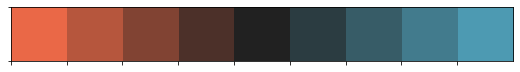

In [36]:
# Color palette
my_color_palette = sns.diverging_palette(20, 220, l=60, n=9, center="dark") 
sns.palplot(my_color_palette)

In [22]:
# Create a new data frame with scaled data
df_scaled = df.drop(columns=[df.columns[-1], 'GROUPE'])
for idx, col in enumerate(df_scaled.columns):
    df_scaled[col] = X_scaled[:, idx]

In [23]:
# Add cluster assignment to data frame
df_scaled['cluster'] = cluster_assignment

In [24]:
# Create a vector of colors corresponding to the 'cluster' column
my_palette = dict(zip(unique(df_scaled.cluster), ["darkorange", "khaki", "sienna"]))
cluster_row_colors = df_scaled.cluster.map(my_palette)

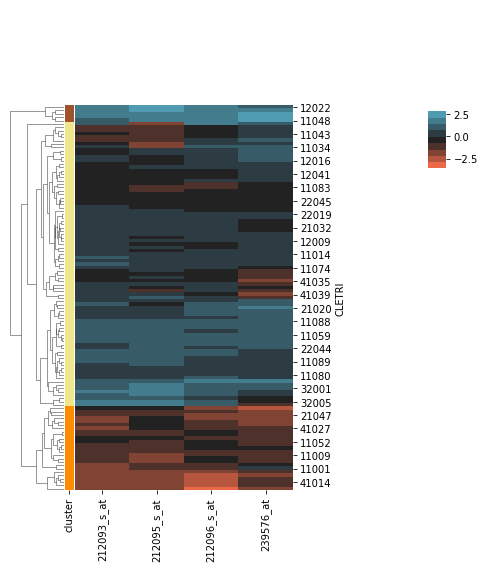

In [37]:
# Plot cluster heatmap + dendrogram
seaborn_cluster = sns.clustermap(df_scaled.drop(columns=['cluster']), 
                                 col_cluster=False, # do not cluster columns
                                 row_linkage=link_matrix, # use previously computed cluster assignment
                                 cbar_pos=(1.2, 0.7, 0.05, 0.1), # position of the colorbar
                                 cmap=my_color_palette,
                                 row_colors=cluster_row_colors, # use cluster colors to color rows on the left
                                 figsize=(5, 8))

In [39]:
seaborn_cluster.savefig('clustering_remagus02.png', bbox_inches='tight')

The orange cluster (number 0) corresponds to low expression across all probes.

## Compare cluster 0 to the one identified by Sylvie

In [26]:
# Restrict df_scaled to the rows for which my cluster assignment is 0
my_atip3_low = df_scaled[df_scaled.cluster==0]
print("We found %d ATIP3 low samples" % len(my_atip3_low))
# Get their names
my_atip3_low_names = my_atip3_low.index
print("Our ATIP3 low samples:", my_atip3_low_names)

We found 25 ATIP3 low samples
Our ATIP3 low samples: Int64Index([11001, 11009, 11013, 11020, 11052, 11075, 11091, 12038, 21024,
            21037, 21047, 22010, 22030, 31022, 41004, 41012, 41014, 41020,
            41027, 41032, 41042, 42002, 42003, 42007, 42012],
           dtype='int64', name='CLETRI')


In [27]:
print("Sylvie's ATIP3 low samples:", sylvie_atip3_low_names)

Sylvie's ATIP3 low samples: Int64Index([11001, 11009, 11013, 11020, 11052, 11075, 11091, 12038, 21024,
            21037, 21047, 22010, 22030, 31022, 41004, 41012, 41014, 41020,
            41027, 41032, 41042, 42002, 42003, 42007, 42012],
           dtype='int64', name='CLETRI')


In [33]:
print("The size of the intersection is:", len(set(my_atip3_low_names).intersection(set(sylvie_atip3_low_names))))
print("There are %d samples that differ" % len(set(my_atip3_low_names).difference(set(sylvie_atip3_low_names))))
      

The size of the intersection is: 25
There are 0 samples that differ
